# 无人机物流仿真系统

## 系统功能概述

本仿真系统实现了一个完整的无人机物流网络，包含以下核心组件：

### 🔋 充电站系统 (MDN服务)
- **多服务窗口设计**：支持N个并行服务窗口
- **固定服务时间**：MDN(Minimal Down Network)服务，服务时间恒定
- **双重电池策略**：
  - 有限电池模式：需充电后再分配给无人机
  - 无限电池模式：即时换电服务

### 🚛 配送中心系统  
- **货物集散功能**：无人机投放货物后由卡车配送
- **固定调度**：卡车按预设时间往返服务点
- **等待机制**：无人机投放后等待卡车返回

### 📍 需求点管理
- **动态需求生成**：基于泊松过程的随机需求
- **智能路径规划**：自动选择最优配送路径
- **资源协调**：多无人机协同作业

### 🎯 系统特点
- 基于SimPy离散事件仿真
- 模块化设计便于扩展
- 完整的性能统计分析
- 可视化结果展示

In [1]:
# 1. 导入所需库和配置
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from typing import List, Dict, Tuple, Optional
import warnings

# 设置随机种子以保证结果可重现
np.random.seed(42)
random.seed(42)

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 忽略警告
warnings.filterwarnings('ignore')

# 全局配置参数
GLOBAL_CONFIG = {
    'simulation_time': 50,
    'area_size': 100,
    'uav_speed_range': (30, 45),
    'battery_capacity': 100,
    'charging_service_time': 0.5,  # 固定服务时间
    'battery_charge_time': 2.0,
    'truck_speed': 50,
    'visualization': True
}

print("📦 无人机物流仿真系统已初始化")
print(f"⚙️ 配置参数: {GLOBAL_CONFIG}")
print("=" * 60)

📦 无人机物流仿真系统已初始化
⚙️ 配置参数: {'simulation_time': 50, 'area_size': 100, 'uav_speed_range': (30, 45), 'battery_capacity': 100, 'charging_service_time': 0.5, 'battery_charge_time': 2.0, 'truck_speed': 50, 'visualization': True}


## 2. 需求点生成系统

实现需求点的坐标生成、需求生成和无人机分配功能。

🗺️ 生成测试坐标...
✅ 坐标生成完成:
   - 顾客点: 5
   - 充电站: 10
   - 配送中心: 3
   - 服务点: 15


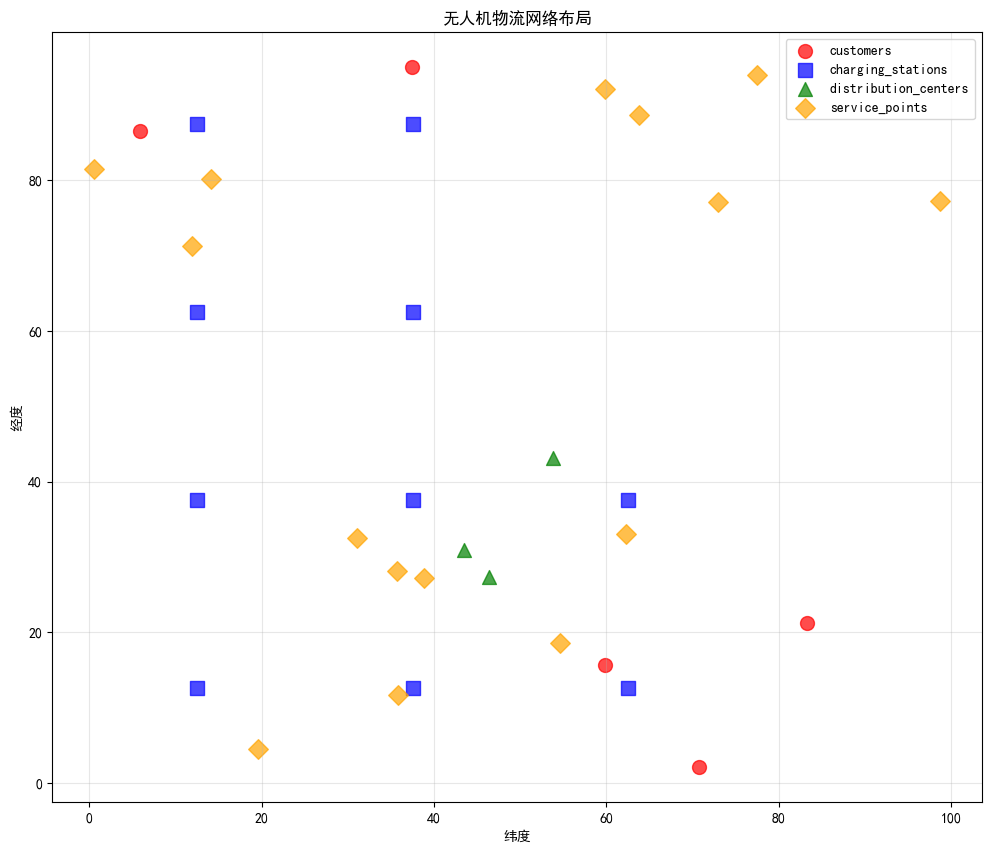

In [2]:
# 2.1 坐标生成函数
def generate_coordinates(num_customers=5, num_charging_stations=10, 
                        num_distribution_centers=3, num_service_points=15, 
                        area_size=100):
    """
    生成各类服务点的坐标
    """
    coordinates = {}
    
    # 生成顾客点坐标
    coordinates['customers'] = []
    for i in range(num_customers):
        x = np.random.uniform(0, area_size)
        y = np.random.uniform(0, area_size)
        coordinates['customers'].append({
            'id': i,
            'latitude': x,
            'longitude': y,
            'demand_rate': np.random.exponential(scale=2.0)
        })
    
    # 生成充电站坐标（网格分布）
    coordinates['charging_stations'] = []
    grid_size = math.ceil(math.sqrt(num_charging_stations))
    for i in range(num_charging_stations):
        row = i // grid_size
        col = i % grid_size
        x = (row + 0.5) * area_size / grid_size
        y = (col + 0.5) * area_size / grid_size
        
        # 随机选择电池类型
        battery_type = np.random.choice(['limited', 'unlimited'], p=[0.6, 0.4])
        
        coordinates['charging_stations'].append({
            'id': i,
            'latitude': x,
            'longitude': y,
            'battery_type': battery_type,
            'battery_capacity': np.random.randint(30, 100) if battery_type == 'limited' else float('inf'),
            'service_windows': np.random.randint(2, 6),  # N个服务窗口
            'service_time': GLOBAL_CONFIG['charging_service_time'],
            'charge_time': GLOBAL_CONFIG['battery_charge_time']
        })
    
    # 生成配送中心坐标
    coordinates['distribution_centers'] = []
    for i in range(num_distribution_centers):
        x = np.random.uniform(area_size*0.2, area_size*0.8)
        y = np.random.uniform(area_size*0.2, area_size*0.8)
        coordinates['distribution_centers'].append({
            'id': i,
            'latitude': x,
            'longitude': y,
            'truck_capacity': np.random.randint(3, 8),
            'truck_speed': GLOBAL_CONFIG['truck_speed'],
            'truck_schedule_interval': np.random.uniform(3.0, 6.0),
            'processing_time': np.random.uniform(0.3, 0.8)
        })
    
    # 生成服务点坐标
    coordinates['service_points'] = []
    for i in range(num_service_points):
        x = np.random.uniform(0, area_size)
        y = np.random.uniform(0, area_size)
        coordinates['service_points'].append({
            'id': i,
            'latitude': x,
            'longitude': y,
            'service_time': np.random.uniform(0.2, 0.8)
        })
    
    return coordinates

def calculate_distance(lat1, lon1, lat2, lon2):
    """计算两点间的欧几里得距离"""
    return math.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

def visualize_coordinates(coordinates):
    """可视化所有坐标点"""
    if not GLOBAL_CONFIG['visualization']:
        return
        
    plt.figure(figsize=(12, 10))
    
    colors = {
        'customers': 'red',
        'charging_stations': 'blue', 
        'distribution_centers': 'green',
        'service_points': 'orange'
    }
    
    markers = {
        'customers': 'o',
        'charging_stations': 's',
        'distribution_centers': '^',
        'service_points': 'D'
    }
    
    for category, points in coordinates.items():
        x_coords = [p['latitude'] for p in points]
        y_coords = [p['longitude'] for p in points]
        plt.scatter(x_coords, y_coords, c=colors[category], 
                   marker=markers[category], s=100, label=category, alpha=0.7)
    
    plt.xlabel('纬度')
    plt.ylabel('经度')
    plt.title('无人机物流网络布局')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 测试坐标生成
print("🗺️ 生成测试坐标...")
test_coordinates = generate_coordinates()
print(f"✅ 坐标生成完成:")
print(f"   - 顾客点: {len(test_coordinates['customers'])}")
print(f"   - 充电站: {len(test_coordinates['charging_stations'])}")
print(f"   - 配送中心: {len(test_coordinates['distribution_centers'])}")
print(f"   - 服务点: {len(test_coordinates['service_points'])}")

visualize_coordinates(test_coordinates)

In [3]:
# 2.2 核心业务类定义
class Goods:
    """货物类"""
    def __init__(self, goods_id, weight=1.0, priority=1, creation_time=0):
        self.goods_id = goods_id
        self.weight = weight
        self.priority = priority
        self.creation_time = creation_time
        self.destination = None
        self.status = 'created'  # created, in_transit, delivered

class Order:
    """订单类"""
    def __init__(self, env, order_id, customer_id, service_point_id, goods, delivery_mode='direct'):
        self.env = env
        self.order_id = order_id
        self.customer_id = customer_id
        self.service_point_id = service_point_id
        self.goods = goods
        self.delivery_mode = delivery_mode  # 'direct' 或 'distribution_center'
        
        self.creation_time = env.now
        self.completion_time = None
        self.assigned_uav = None
        self.status = 'pending'  # pending, assigned, in_progress, completed
        
        # 路径信息
        self.path = []
        self.distances = []

class UAV:
    """无人机类（基于原始代码改进）"""
    def __init__(self, env, uav_id, latitude, longitude, speed=35, 
                 battery_capacity=100, max_payload=2.0):
        self.env = env
        self.uav_id = uav_id
        self.latitude = latitude
        self.longitude = longitude
        self.current_latitude = latitude
        self.current_longitude = longitude
        self.speed = speed
        self.battery_capacity = battery_capacity
        self.current_battery = battery_capacity
        self.max_payload = max_payload
        
        # 状态信息
        self.busy = False
        self.current_order = None
        self.target = 0  # 当前路径目标点索引
        
        # 统计信息
        self.total_orders_completed = 0
        self.total_flight_time = 0
        self.total_distance = 0
        self.service_start_time = 0
        self.waiting_time = 0
    
    def execute_direct_delivery(self, order, charging_stations, service_points):
        """执行直接配送任务"""
        self.busy = True
        self.current_order = order
        order.status = 'in_progress'
        start_time = self.env.now
        
        print(f"🚁 UAV {self.uav_id} 开始直接配送订单 {order.order_id} (时间: {self.env.now:.2f})")
        
        # 获取目标服务点
        target_service_point = service_points[order.service_point_id]
        target_lat = target_service_point['latitude']
        target_lon = target_service_point['longitude']
        
        # 计算距离并检查是否需要充电
        distance_to_target = calculate_distance(
            self.current_latitude, self.current_longitude, target_lat, target_lon
        )
        
        # 如果距离太远，需要先充电
        if distance_to_target > self.current_battery * 0.8:
            yield self.env.process(self._find_and_charge(charging_stations))
        
        # 飞行到服务点
        yield self.env.process(self._fly_to_location(target_lat, target_lon))
        
        # 服务时间
        service_time = target_service_point['service_time']
        yield self.env.timeout(service_time)
        
        # 返回基地
        yield self.env.process(self._fly_to_location(self.latitude, self.longitude))
        
        # 完成订单
        self._complete_order(order, start_time)
    
    def execute_distribution_delivery(self, order, charging_stations, distribution_centers):
        """执行通过配送中心的配送"""
        self.busy = True
        self.current_order = order
        order.status = 'in_progress'
        start_time = self.env.now
        
        print(f"🚁 UAV {self.uav_id} 开始配送中心配送订单 {order.order_id} (时间: {self.env.now:.2f})")
        
        # 寻找最近的配送中心
        nearest_dc = self._find_nearest_distribution_center(distribution_centers)
        
        if nearest_dc:
            dc_lat = nearest_dc['latitude']
            dc_lon = nearest_dc['longitude']
            
            # 检查是否需要充电
            distance_to_dc = calculate_distance(
                self.current_latitude, self.current_longitude, dc_lat, dc_lon
            )
            
            if distance_to_dc > self.current_battery * 0.8:
                yield self.env.process(self._find_and_charge(charging_stations))
            
            # 飞行到配送中心
            yield self.env.process(self._fly_to_location(dc_lat, dc_lon))
            
            # 在配送中心投放货物
            yield self.env.timeout(nearest_dc['processing_time'])
            print(f"📦 UAV {self.uav_id} 在配送中心 {nearest_dc['id']} 投放货物")
            
            # 等待卡车返回（简化处理）
            truck_wait_time = nearest_dc['truck_schedule_interval']
            yield self.env.timeout(truck_wait_time)
            print(f"🚛 UAV {self.uav_id} 等待卡车配送完成")
            
            # 返回基地
            yield self.env.process(self._fly_to_location(self.latitude, self.longitude))
            
            # 完成订单
            self._complete_order(order, start_time)
    
    def _fly_to_location(self, target_lat, target_lon):
        """飞行到指定位置"""
        distance = calculate_distance(
            self.current_latitude, self.current_longitude, target_lat, target_lon
        )
        flight_time = distance / self.speed
        battery_consumption = distance * 0.5
        
        yield self.env.timeout(flight_time)
        
        self.current_latitude = target_lat
        self.current_longitude = target_lon
        self.current_battery -= battery_consumption
        self.total_distance += distance
        
        print(f"✈️ UAV {self.uav_id} 到达 ({target_lat:.1f}, {target_lon:.1f}), 电池: {self.current_battery:.1f}")
    
    def _find_and_charge(self, charging_stations):
        """寻找并前往充电站充电"""
        # 寻找最近的充电站
        nearest_station = None
        min_distance = float('inf')
        
        for station in charging_stations:
            distance = calculate_distance(
                self.current_latitude, self.current_longitude,
                station['latitude'], station['longitude']
            )
            if distance < min_distance:
                min_distance = distance
                nearest_station = station
        
        if nearest_station:
            # 飞行到充电站
            yield self.env.process(self._fly_to_location(
                nearest_station['latitude'], nearest_station['longitude']
            ))
            
            # 充电时间（简化处理）
            charge_time = nearest_station['service_time']
            yield self.env.timeout(charge_time)
            
            # 重置电池
            self.current_battery = self.battery_capacity
            print(f"🔋 UAV {self.uav_id} 在充电站 {nearest_station['id']} 充电完成")
    
    def _find_nearest_distribution_center(self, distribution_centers):
        """寻找最近的配送中心"""
        nearest_dc = None
        min_distance = float('inf')
        
        for dc in distribution_centers:
            distance = calculate_distance(
                self.current_latitude, self.current_longitude,
                dc['latitude'], dc['longitude']
            )
            if distance < min_distance:
                min_distance = distance
                nearest_dc = dc
        
        return nearest_dc
    
    def _complete_order(self, order, start_time):
        """完成订单"""
        self.total_orders_completed += 1
        self.total_flight_time += (self.env.now - start_time)
        order.completion_time = self.env.now
        order.status = 'completed'
        
        print(f"✅ UAV {self.uav_id} 完成订单 {order.order_id} (耗时: {self.env.now - start_time:.2f})")
        
        self.busy = False
        self.current_order = None

# 测试无人机类
print("🚁 无人机类定义完成")
print("✅ 支持直接配送和配送中心两种模式")

🚁 无人机类定义完成
✅ 支持直接配送和配送中心两种模式


In [4]:
# 2.3 需求点类（基于原始代码改进）
class DemandPoint:
    """需求点类 - 负责生成需求和管理无人机"""
    def __init__(self, env, demand_point_id, latitude, longitude, 
                 uav_count=3, demand_time=2.0):
        self.env = env
        self.demand_point_id = demand_point_id
        self.latitude = latitude
        self.longitude = longitude
        self.uav_count = uav_count
        self.demand_time = demand_time
        self.orders_generated = 0
        
        # 无人机队列
        self.uav_queue = []
        self.busy_uavs = []
        
        # 统计信息
        self.total_orders_generated = 0
        self.completed_orders = []
        
        # 初始化无人机
        self._initialize_uavs()
        
        # 启动需求生成进程
        self.env.process(self.generate_demand_process())
    
    def _initialize_uavs(self):
        """初始化无人机队列"""
        for i in range(self.uav_count):
            uav_id = f"{self.demand_point_id}_{i}"
            speed = np.random.uniform(*GLOBAL_CONFIG['uav_speed_range'])
            uav = UAV(self.env, uav_id, self.latitude, self.longitude, 
                     speed=speed, battery_capacity=GLOBAL_CONFIG['battery_capacity'])
            self.uav_queue.append(uav)
    
    def generate_demand_process(self):
        """需求生成进程"""
        while True:
            # 等待下一个需求
            yield self.env.timeout(np.random.exponential(scale=self.demand_time))
            
            # 创建新订单
            order_id = f"{self.demand_point_id}_{self.orders_generated}"
            self.orders_generated += 1
            self.total_orders_generated += 1
            
            # 随机选择服务点（简化处理）
            service_point_id = np.random.randint(0, 15)  # 假设有15个服务点
            
            # 创建货物
            goods = Goods(
                goods_id=f"goods_{order_id}",
                weight=np.random.uniform(0.5, 2.0),
                priority=np.random.randint(1, 4),
                creation_time=self.env.now
            )
            
            # 决定配送模式（距离超过50选择配送中心）
            distance_to_service = np.random.uniform(20, 80)  # 简化距离计算
            delivery_mode = 'distribution_center' if distance_to_service > 50 else 'direct'
            
            # 创建订单
            order = Order(
                self.env, order_id, self.demand_point_id, 
                service_point_id, goods, delivery_mode
            )
            
            print(f"📋 需求点 {self.demand_point_id} 生成订单 {order_id} (模式: {delivery_mode})")
            
            # 分配无人机
            self._assign_uav_to_order(order)
    
    def _assign_uav_to_order(self, order):
        """为订单分配无人机"""
        if len(self.uav_queue) > 0:
            # 选择电池最充足的无人机
            available_uav = max(self.uav_queue, key=lambda x: x.current_battery)
            self.uav_queue.remove(available_uav)
            self.busy_uavs.append(available_uav)
            
            order.assigned_uav = available_uav
            order.status = 'assigned'
            
            print(f"🎯 订单 {order.order_id} 分配给 UAV {available_uav.uav_id}")
            
            # 启动订单执行进程
            self.env.process(self._execute_order(available_uav, order))
        else:
            print(f"⏳ 订单 {order.order_id} 等待可用无人机")
            # 在实际实现中应该将订单加入等待队列
    
    def _execute_order(self, uav, order):
        """执行订单"""
        try:
            if order.delivery_mode == 'direct':
                # 假设已经有充电站和服务点数据
                charging_stations = test_coordinates['charging_stations']
                service_points = test_coordinates['service_points']
                yield self.env.process(uav.execute_direct_delivery(
                    order, charging_stations, service_points
                ))
            else:
                # 配送中心模式
                charging_stations = test_coordinates['charging_stations']
                distribution_centers = test_coordinates['distribution_centers']
                yield self.env.process(uav.execute_distribution_delivery(
                    order, charging_stations, distribution_centers
                ))
            
            # 订单完成后，将无人机返回队列
            self.busy_uavs.remove(uav)
            self.uav_queue.append(uav)
            self.completed_orders.append(order)
            
        except Exception as e:
            print(f"❌ 订单执行错误: {e}")
    
    def get_statistics(self):
        """获取统计信息"""
        return {
            'demand_point_id': self.demand_point_id,
            'total_orders_generated': self.total_orders_generated,
            'completed_orders': len(self.completed_orders),
            'available_uavs': len(self.uav_queue),
            'busy_uavs': len(self.busy_uavs),
            'completion_rate': len(self.completed_orders) / max(1, self.total_orders_generated) * 100
        }

print("📍 需求点类定义完成")
print("✅ 支持自动需求生成和无人机调度")

📍 需求点类定义完成
✅ 支持自动需求生成和无人机调度


## 3. 充电站仿真系统 (MDN服务)

实现多服务窗口的充电站，支持有限/无限电池策略和固定服务时间。

In [6]:
# 3.1 充电站类（MDN服务 - 多服务窗口 + 有限/无限电池策略）
class ChargingStation:
    """
    充电站类 - MDN服务模式
    特点：
    1. 多服务窗口 (N个并行服务)
    2. 固定服务时间
    3. 两种电池策略：有限/无限
    """
    def __init__(self, env, station_id, latitude, longitude, 
                 battery_type='limited', battery_capacity=50, 
                 service_windows=3, service_time=0.5, charge_time=2.0, 
                 min_battery_count=5):
        self.env = env
        self.station_id = station_id
        self.latitude = latitude
        self.longitude = longitude
        self.battery_type = battery_type  # 'limited' 或 'unlimited'
        self.battery_capacity = battery_capacity if battery_type == 'limited' else float('inf')
        self.current_battery_count = battery_capacity if battery_type == 'limited' else float('inf')
        self.service_windows = service_windows  # N个服务窗口
        self.service_time = service_time  # 固定服务时间
        self.charge_time = charge_time
        self.min_battery_count = min_battery_count
        
        # 创建服务窗口资源
        self.service_resource = simpy.Resource(env, capacity=service_windows)
        
        # 队列管理
        self.waiting_queue = []
        self.charging_batteries = []  # 正在充电的电池
        
        # 统计信息
        self.total_served = 0
        self.total_waiting_time = 0
        self.queue_lengths = []
        self.service_times = []
        
        # 启动电池充电进程（仅限有限电池模式）
        if self.battery_type == 'limited':
            self.env.process(self.battery_charging_process())
        
        # 启动统计收集进程
        self.env.process(self.statistics_collection())
    
    def battery_charging_process(self):
        """电池充电进程（仅限有限电池模式）"""
        while True:
            if len(self.charging_batteries) > 0:
                # 处理正在充电的电池
                completed_batteries = []
                for battery in self.charging_batteries:
                    if self.env.now >= battery['completion_time']:
                        completed_batteries.append(battery)
                        self.current_battery_count += 1
                        print(f"🔋 充电站 {self.station_id} 电池充电完成，当前电池数: {self.current_battery_count}")
                
                # 移除已完成充电的电池
                for battery in completed_batteries:
                    self.charging_batteries.remove(battery)
            
            yield self.env.timeout(0.1)  # 检查频率
    
    def serve_uav(self, uav):
        """为无人机提供服务"""
        arrival_time = self.env.now
        self.waiting_queue.append(uav)
        
        print(f"🚁 UAV {uav.uav_id} 到达充电站 {self.station_id} (时间: {self.env.now:.2f})")
        
        # 请求服务窗口
        with self.service_resource.request() as request:
            yield request
            
            # 移除等待队列
            if uav in self.waiting_queue:
                self.waiting_queue.remove(uav)
            
            # 检查电池可用性
            while True:
                if self.battery_type == 'unlimited':
                    # 无限电池模式 - 直接服务
                    break
                elif self.current_battery_count > self.min_battery_count:
                    # 有限电池模式 - 有足够电池
                    break
                else:
                    # 等待电池充电完成
                    print(f"⏳ 充电站 {self.station_id} 电池不足，UAV {uav.uav_id} 等待...")
                    yield self.env.timeout(0.5)
            
            # 开始服务
            waiting_time = self.env.now - arrival_time
            self.total_waiting_time += waiting_time
            
            print(f"🔧 充电站 {self.station_id} 开始为 UAV {uav.uav_id} 服务 (等待时间: {waiting_time:.2f})")
            
            # 固定服务时间（MDN特征）
            yield self.env.timeout(self.service_time)
            
            # 电池管理
            if self.battery_type == 'limited':
                # 有限电池模式：消耗电池，启动废电池充电
                self.current_battery_count -= 1
                used_battery = {
                    'start_time': self.env.now,
                    'completion_time': self.env.now + self.charge_time
                }
                self.charging_batteries.append(used_battery)
                print(f"🔄 充电站 {self.station_id} 废电池开始充电，剩余电池: {self.current_battery_count}")
            
            # 完成服务
            uav.current_battery = uav.battery_capacity
            self.total_served += 1
            
            print(f"✅ 充电站 {self.station_id} 完成为 UAV {uav.uav_id} 服务 (时间: {self.env.now:.2f})")
    
    def statistics_collection(self):
        """统计信息收集"""
        while True:
            self.queue_lengths.append(len(self.waiting_queue))
            yield self.env.timeout(1.0)  # 每时间单位收集一次
    
    def get_statistics(self):
        """获取统计信息"""
        avg_waiting_time = self.total_waiting_time / max(1, self.total_served)
        avg_queue_length = np.mean(self.queue_lengths) if self.queue_lengths else 0
        
        return {
            'station_id': self.station_id,
            'battery_type': self.battery_type,
            'service_windows': self.service_windows,
            'total_served': self.total_served,
            'avg_waiting_time': avg_waiting_time,
            'avg_queue_length': avg_queue_length,
            'current_battery_count': self.current_battery_count if self.battery_type == 'limited' else '∞',
            'current_queue_length': len(self.waiting_queue),
            'charging_batteries': len(self.charging_batteries) if self.battery_type == 'limited' else 0
        }

print("🔋 充电站类定义完成")
print("✅ 特性：MDN服务 + 多服务窗口 + 有限/无限电池策略")

🔋 充电站类定义完成
✅ 特性：MDN服务 + 多服务窗口 + 有限/无限电池策略


In [7]:
# 3.2 充电站功能测试
def test_charging_station():
    """测试充电站功能"""
    print("🧪 开始充电站功能测试...")
    
    # 创建测试环境
    env = simpy.Environment()
    
    # 创建两种类型的充电站
    limited_station = ChargingStation(
        env, 0, 50, 50, 
        battery_type='limited', 
        battery_capacity=10, 
        service_windows=3,
        service_time=0.5,
        charge_time=2.0
    )
    
    unlimited_station = ChargingStation(
        env, 1, 60, 60,
        battery_type='unlimited',
        service_windows=2,
        service_time=0.3
    )
    
    # 创建测试无人机
    def uav_arrival_process():
        for i in range(8):
            # 创建测试无人机
            uav = UAV(env, f"test_uav_{i}", 50, 50, speed=30)
            uav.current_battery = 20  # 设置低电量
            
            # 随机选择充电站
            if i % 2 == 0:
                env.process(limited_station.serve_uav(uav))
            else:
                env.process(unlimited_station.serve_uav(uav))
            
            yield env.timeout(np.random.exponential(0.8))  # 无人机到达间隔
    
    env.process(uav_arrival_process())
    
    # 运行测试
    env.run(until=15)
    
    # 输出测试结果
    print("\n📊 充电站测试结果:")
    print("=" * 50)
    
    limited_stats = limited_station.get_statistics()
    unlimited_stats = unlimited_station.get_statistics()
    
    print(f"🔋 有限电池充电站 (ID: {limited_stats['station_id']}):")
    print(f"   - 服务窗口数: {limited_stats['service_windows']}")
    print(f"   - 总服务次数: {limited_stats['total_served']}")
    print(f"   - 平均等待时间: {limited_stats['avg_waiting_time']:.2f}")
    print(f"   - 当前电池数: {limited_stats['current_battery_count']}")
    print(f"   - 正在充电电池: {limited_stats['charging_batteries']}")
    
    print(f"\n🔋 无限电池充电站 (ID: {unlimited_stats['station_id']}):")
    print(f"   - 服务窗口数: {unlimited_stats['service_windows']}")
    print(f"   - 总服务次数: {unlimited_stats['total_served']}")
    print(f"   - 平均等待时间: {unlimited_stats['avg_waiting_time']:.2f}")
    print(f"   - 电池模式: {unlimited_stats['battery_type']}")
    
    return limited_station, unlimited_station

# 运行充电站测试
test_charging_station()

🧪 开始充电站功能测试...
🚁 UAV test_uav_0 到达充电站 0 (时间: 0.00)
🔧 充电站 0 开始为 UAV test_uav_0 服务 (等待时间: 0.00)
🔄 充电站 0 废电池开始充电，剩余电池: 9
✅ 充电站 0 完成为 UAV test_uav_0 服务 (时间: 0.50)
🚁 UAV test_uav_1 到达充电站 1 (时间: 0.66)
🔧 充电站 1 开始为 UAV test_uav_1 服务 (等待时间: 0.00)
✅ 充电站 1 完成为 UAV test_uav_1 服务 (时间: 0.96)
🚁 UAV test_uav_2 到达充电站 0 (时间: 1.84)
🔧 充电站 0 开始为 UAV test_uav_2 服务 (等待时间: 0.00)
🔄 充电站 0 废电池开始充电，剩余电池: 8
✅ 充电站 0 完成为 UAV test_uav_2 服务 (时间: 2.34)
🚁 UAV test_uav_3 到达充电站 1 (时间: 2.38)
🔧 充电站 1 开始为 UAV test_uav_3 服务 (等待时间: 0.00)
🔋 充电站 0 电池充电完成，当前电池数: 9
✅ 充电站 1 完成为 UAV test_uav_3 服务 (时间: 2.68)
🚁 UAV test_uav_4 到达充电站 0 (时间: 2.97)
🔧 充电站 0 开始为 UAV test_uav_4 服务 (等待时间: 0.00)
🚁 UAV test_uav_5 到达充电站 1 (时间: 3.42)
🔧 充电站 1 开始为 UAV test_uav_5 服务 (等待时间: 0.00)
🚁 UAV test_uav_6 到达充电站 0 (时间: 3.44)
🔧 充电站 0 开始为 UAV test_uav_6 服务 (等待时间: 0.00)
🔄 充电站 0 废电池开始充电，剩余电池: 8
✅ 充电站 0 完成为 UAV test_uav_4 服务 (时间: 3.47)
🚁 UAV test_uav_7 到达充电站 1 (时间: 3.53)
🔧 充电站 1 开始为 UAV test_uav_7 服务 (等待时间: 0.00)
✅ 充电站 1 完成为 UAV test_uav_5 服务 (时间: 3.72)
✅ 充电站 1 完成为

(<__main__.ChargingStation at 0x1ca9b3ca090>,
 <__main__.ChargingStation at 0x1ca9b3e3890>)

## 4. 配送中心仿真系统

实现配送中心的货物接收、处理和卡车调度功能。

In [8]:
# 4.1 卡车类（基于原始代码改进）
class Truck:
    """
    卡车类 - 负责在配送中心和服务点之间运输货物
    特点：固定时间往返调度
    """
    def __init__(self, env, truck_id, base_latitude, base_longitude, 
                 speed=50, capacity=5, distribution_center_id=0):
        self.env = env
        self.truck_id = truck_id
        self.base_latitude = base_latitude
        self.base_longitude = base_longitude
        self.current_latitude = base_latitude
        self.current_longitude = base_longitude
        self.speed = speed
        self.capacity = capacity
        self.distribution_center_id = distribution_center_id
        self.busy = False
        
        # 货物管理
        self.current_load = []
        self.max_load = capacity
        
        # 统计信息
        self.total_trips = 0
        self.total_distance = 0
        self.total_delivery_time = 0
        self.goods_delivered = 0
    
    def scheduled_delivery_trip(self, service_points, delivery_goods):
        """执行固定调度的配送行程"""
        if self.busy or len(delivery_goods) == 0:
            return
        
        self.busy = True
        trip_start_time = self.env.now
        
        # 装载货物（最多装载容量限制）
        goods_to_deliver = delivery_goods[:self.capacity]
        self.current_load = goods_to_deliver
        
        print(f"🚛 卡车 {self.truck_id} 开始配送行程，装载货物 {len(goods_to_deliver)} 件 (时间: {self.env.now:.2f})")
        
        # 按目的地分组货物
        delivery_destinations = {}
        for goods in goods_to_deliver:
            dest_id = goods.destination
            if dest_id not in delivery_destinations:
                delivery_destinations[dest_id] = []
            delivery_destinations[dest_id].append(goods)
        
        trip_distance = 0
        
        # 访问每个目的地
        for dest_id, goods_list in delivery_destinations.items():
            # 获取目的地坐标（简化处理）
            if dest_id < len(service_points):
                target_point = service_points[dest_id]
                target_lat = target_point['latitude']
                target_lon = target_point['longitude']
            else:
                # 随机生成目的地坐标
                target_lat = np.random.uniform(0, GLOBAL_CONFIG['area_size'])
                target_lon = np.random.uniform(0, GLOBAL_CONFIG['area_size'])
            
            # 计算行驶时间
            distance = calculate_distance(
                self.current_latitude, self.current_longitude,
                target_lat, target_lon
            )
            travel_time = distance / self.speed
            trip_distance += distance
            
            # 行驶到目的地
            yield self.env.timeout(travel_time)
            
            # 更新当前位置
            self.current_latitude = target_lat
            self.current_longitude = target_lon
            
            # 卸货时间
            unload_time = len(goods_list) * 0.1  # 每件货物0.1时间单位
            yield self.env.timeout(unload_time)
            
            self.goods_delivered += len(goods_list)
            
            print(f"📦 卡车 {self.truck_id} 在目的地 {dest_id} 卸货 {len(goods_list)} 件")
        
        # 返回配送中心
        return_distance = calculate_distance(
            self.current_latitude, self.current_longitude,
            self.base_latitude, self.base_longitude
        )
        return_time = return_distance / self.speed
        trip_distance += return_distance
        
        yield self.env.timeout(return_time)
        
        # 重置位置和状态
        self.current_latitude = self.base_latitude
        self.current_longitude = self.base_longitude
        self.current_load = []
        self.busy = False
        
        # 更新统计信息
        self.total_trips += 1
        self.total_distance += trip_distance
        self.total_delivery_time += (self.env.now - trip_start_time)
        
        print(f"🏠 卡车 {self.truck_id} 返回配送中心 (行程时间: {self.env.now - trip_start_time:.2f})")
    
    def get_statistics(self):
        """获取卡车统计信息"""
        avg_trip_time = self.total_delivery_time / max(1, self.total_trips)
        return {
            'truck_id': self.truck_id,
            'total_trips': self.total_trips,
            'total_distance': self.total_distance,
            'total_delivery_time': self.total_delivery_time,
            'goods_delivered': self.goods_delivered,
            'avg_trip_time': avg_trip_time,
            'busy': self.busy
        }

print("🚛 卡车类定义完成")
print("✅ 支持固定调度和批量配送")

🚛 卡车类定义完成
✅ 支持固定调度和批量配送


In [9]:
# 4.2 配送中心类（基于原始代码改进）
class DistributionCenter:
    """
    配送中心类 - 接收无人机货物并协调卡车配送
    特点：
    1. 不提供无人机充电服务
    2. 卡车按固定时间调度
    3. 无人机投放货物后等待卡车返回
    """
    def __init__(self, env, center_id, latitude, longitude, 
                 truck_count=2, truck_capacity=5, truck_speed=50, 
                 processing_time=0.5, schedule_interval=4.0):
        self.env = env
        self.center_id = center_id
        self.latitude = latitude
        self.longitude = longitude
        self.truck_count = truck_count
        self.truck_capacity = truck_capacity
        self.truck_speed = truck_speed
        self.processing_time = processing_time
        self.schedule_interval = schedule_interval  # 固定调度间隔
        
        # 卡车队列
        self.trucks = []
        self._initialize_trucks()
        
        # 货物管理
        self.incoming_goods = []  # 无人机投放的货物
        self.processed_goods = []  # 已处理待配送的货物
        self.waiting_uavs = []  # 等待卡车返回的无人机
        
        # 统计信息
        self.total_goods_received = 0
        self.total_goods_delivered = 0
        self.total_processing_time = 0
        self.uav_waiting_times = []
        
        # 启动处理进程
        self.env.process(self.goods_processing())
        self.env.process(self.truck_scheduling())
    
    def _initialize_trucks(self):
        """初始化卡车队列"""
        for i in range(self.truck_count):
            truck_id = f"{self.center_id}_truck_{i}"
            truck = Truck(
                self.env, truck_id, self.latitude, self.longitude,
                speed=self.truck_speed, capacity=self.truck_capacity,
                distribution_center_id=self.center_id
            )
            self.trucks.append(truck)
    
    def receive_goods_from_uav(self, uav, goods_list):
        """接收无人机投放的货物"""
        arrival_time = self.env.now
        
        # 如果传入的是单个货物，转换为列表
        if not isinstance(goods_list, list):
            goods_list = [goods_list]
        
        print(f"📦 配送中心 {self.center_id} 接收来自 UAV {uav.uav_id} 的 {len(goods_list)} 件货物")
        
        # 添加到incoming队列
        for goods in goods_list:
            goods.arrival_time = arrival_time
            self.incoming_goods.append(goods)
        
        # 将无人机加入等待队列
        uav.dc_arrival_time = arrival_time
        self.waiting_uavs.append(uav)
        
        self.total_goods_received += len(goods_list)
        
        return True
    
    def goods_processing(self):
        """货物处理进程"""
        while True:
            if len(self.incoming_goods) > 0:
                goods = self.incoming_goods.pop(0)
                
                # 处理时间
                processing_time = np.random.exponential(scale=self.processing_time)
                yield self.env.timeout(processing_time)
                
                # 设置目的地（简化处理）
                if not hasattr(goods, 'destination') or goods.destination is None:
                    goods.destination = np.random.randint(0, 15)  # 随机选择服务点
                
                goods.status = 'processed'
                self.processed_goods.append(goods)
                self.total_processing_time += processing_time
                
                print(f"⚙️ 配送中心 {self.center_id} 处理完成货物 {goods.goods_id}")
            else:
                yield self.env.timeout(0.5)  # 等待新货物
    
    def truck_scheduling(self):
        """卡车固定调度进程"""
        while True:
            # 等待调度间隔
            yield self.env.timeout(self.schedule_interval)
            
            if len(self.processed_goods) > 0:
                # 寻找可用卡车
                available_truck = None
                for truck in self.trucks:
                    if not truck.busy:
                        available_truck = truck
                        break
                
                if available_truck and len(self.processed_goods) > 0:
                    # 分配货物给卡车
                    delivery_goods = []
                    remaining_capacity = available_truck.capacity
                    
                    while len(self.processed_goods) > 0 and remaining_capacity > 0:
                        goods = self.processed_goods.pop(0)
                        delivery_goods.append(goods)
                        remaining_capacity -= 1
                    
                    if delivery_goods:
                        print(f"🚛 调度卡车 {available_truck.truck_id} 配送 {len(delivery_goods)} 件货物")
                        
                        # 启动配送任务
                        self.env.process(
                            self._execute_delivery_and_return(available_truck, delivery_goods)
                        )
    
    def _execute_delivery_and_return(self, truck, delivery_goods):
        """执行配送并处理返回"""
        # 执行配送行程
        yield self.env.process(truck.scheduled_delivery_trip(
            test_coordinates['service_points'], delivery_goods
        ))
        
        # 卡车返回后，释放等待的无人机
        self.total_goods_delivered += len(delivery_goods)
        
        # 释放等待的无人机（简化处理：按先到先服务）
        uavs_to_release = min(len(self.waiting_uavs), len(delivery_goods))
        
        for i in range(uavs_to_release):
            if len(self.waiting_uavs) > 0:
                uav = self.waiting_uavs.pop(0)
                waiting_time = self.env.now - uav.dc_arrival_time
                self.uav_waiting_times.append(waiting_time)
                
                print(f"🚁 UAV {uav.uav_id} 可以离开配送中心 (等待时间: {waiting_time:.2f})")
    
    def get_statistics(self):
        """获取配送中心统计信息"""
        avg_processing_time = self.total_processing_time / max(1, self.total_goods_received)
        avg_uav_waiting_time = np.mean(self.uav_waiting_times) if self.uav_waiting_times else 0
        
        # 卡车统计
        truck_stats = [truck.get_statistics() for truck in self.trucks]
        
        return {
            'center_id': self.center_id,
            'truck_count': self.truck_count,
            'schedule_interval': self.schedule_interval,
            'total_goods_received': self.total_goods_received,
            'total_goods_delivered': self.total_goods_delivered,
            'avg_processing_time': avg_processing_time,
            'avg_uav_waiting_time': avg_uav_waiting_time,
            'pending_goods': len(self.processed_goods),
            'waiting_uavs': len(self.waiting_uavs),
            'truck_statistics': truck_stats
        }

print("🏢 配送中心类定义完成")
print("✅ 特性：固定调度 + 货物处理 + UAV等待管理")

🏢 配送中心类定义完成
✅ 特性：固定调度 + 货物处理 + UAV等待管理


In [10]:
# 4.3 配送中心功能测试
def test_distribution_center():
    """测试配送中心功能"""
    print("🧪 开始配送中心功能测试...")
    
    # 创建测试环境
    env = simpy.Environment()
    
    # 创建配送中心
    dc = DistributionCenter(
        env, center_id=0, latitude=50, longitude=50,
        truck_count=2, truck_capacity=4, truck_speed=60,
        processing_time=0.3, schedule_interval=3.0
    )
    
    # 模拟无人机投放货物
    def uav_delivery_simulation():
        for i in range(10):
            # 创建测试无人机
            uav = UAV(env, f"delivery_uav_{i}", 50, 50)
            
            # 创建货物
            goods_count = np.random.randint(1, 4)  # 每次投放1-3件货物
            goods_list = []
            for j in range(goods_count):
                goods = Goods(
                    goods_id=f"goods_{i}_{j}",
                    weight=np.random.uniform(0.5, 2.0),
                    creation_time=env.now
                )
                goods.destination = np.random.randint(0, 8)  # 随机目的地
                goods_list.append(goods)
            
            # 无人机投放货物
            dc.receive_goods_from_uav(uav, goods_list)
            
            print(f"🚁 UAV {uav.uav_id} 投放 {len(goods_list)} 件货物到配送中心")
            
            # 间隔时间
            yield env.timeout(np.random.exponential(1.5))
    
    env.process(uav_delivery_simulation())
    
    # 运行测试
    env.run(until=20)
    
    # 输出测试结果
    print("\n📊 配送中心测试结果:")
    print("=" * 50)
    
    dc_stats = dc.get_statistics()
    
    print(f"🏢 配送中心 {dc_stats['center_id']} 统计:")
    print(f"   - 调度间隔: {dc_stats['schedule_interval']:.1f} 时间单位")
    print(f"   - 接收货物总数: {dc_stats['total_goods_received']}")
    print(f"   - 配送货物总数: {dc_stats['total_goods_delivered']}")
    print(f"   - 平均处理时间: {dc_stats['avg_processing_time']:.2f}")
    print(f"   - 平均UAV等待时间: {dc_stats['avg_uav_waiting_time']:.2f}")
    print(f"   - 待配送货物: {dc_stats['pending_goods']}")
    print(f"   - 等待中的UAV: {dc_stats['waiting_uavs']}")
    
    print(f"\n🚛 卡车性能统计:")
    for truck_stat in dc_stats['truck_statistics']:
        print(f"   - 卡车 {truck_stat['truck_id']}:")
        print(f"     * 配送行程: {truck_stat['total_trips']}")
        print(f"     * 配送货物: {truck_stat['goods_delivered']}")
        print(f"     * 总行程时间: {truck_stat['total_delivery_time']:.2f}")
        print(f"     * 平均行程时间: {truck_stat['avg_trip_time']:.2f}")
    
    return dc

# 运行配送中心测试
test_distribution_center()

🧪 开始配送中心功能测试...
📦 配送中心 0 接收来自 UAV delivery_uav_0 的 3 件货物
🚁 UAV delivery_uav_0 投放 3 件货物到配送中心
📦 配送中心 0 接收来自 UAV delivery_uav_1 的 1 件货物
🚁 UAV delivery_uav_1 投放 1 件货物到配送中心
⚙️ 配送中心 0 处理完成货物 goods_0_0
⚙️ 配送中心 0 处理完成货物 goods_0_1
⚙️ 配送中心 0 处理完成货物 goods_0_2
⚙️ 配送中心 0 处理完成货物 goods_1_0
📦 配送中心 0 接收来自 UAV delivery_uav_2 的 1 件货物
🚁 UAV delivery_uav_2 投放 1 件货物到配送中心
📦 配送中心 0 接收来自 UAV delivery_uav_3 的 2 件货物
🚁 UAV delivery_uav_3 投放 2 件货物到配送中心
🚛 调度卡车 0_truck_0 配送 4 件货物
🚛 卡车 0_truck_0 开始配送行程，装载货物 4 件 (时间: 3.00)
📦 卡车 0_truck_0 在目的地 4 卸货 1 件
📦 配送中心 0 接收来自 UAV delivery_uav_4 的 1 件货物
🚁 UAV delivery_uav_4 投放 1 件货物到配送中心
📦 配送中心 0 接收来自 UAV delivery_uav_5 的 1 件货物
🚁 UAV delivery_uav_5 投放 1 件货物到配送中心
⚙️ 配送中心 0 处理完成货物 goods_2_0
📦 卡车 0_truck_0 在目的地 5 卸货 1 件
📦 配送中心 0 接收来自 UAV delivery_uav_6 的 2 件货物
🚁 UAV delivery_uav_6 投放 2 件货物到配送中心
⚙️ 配送中心 0 处理完成货物 goods_3_0
⚙️ 配送中心 0 处理完成货物 goods_3_1
⚙️ 配送中心 0 处理完成货物 goods_4_0
⚙️ 配送中心 0 处理完成货物 goods_5_0
📦 卡车 0_truck_0 在目的地 6 卸货 1 件
⚙️ 配送中心 0 处理完成货物 goods_6_0
📦 卡车 0_truck_0 在目的地 2 卸货 1 

## 5. 完整仿真系统集成

将所有组件集成到一个完整的无人机物流仿真系统中。

In [11]:
# 5.1 完整无人机物流仿真系统
class CompleteUAVLogisticsSimulation:
    """
    完整的无人机物流仿真系统
    集成所有组件：需求点、充电站、配送中心、无人机、卡车
    """
    def __init__(self, coordinates, simulation_time=50):
        self.env = simpy.Environment()
        self.coordinates = coordinates
        self.simulation_time = simulation_time
        
        # 系统组件
        self.demand_points = {}
        self.charging_stations = {}
        self.distribution_centers = {}
        self.all_orders = []
        self.completed_orders = []
        
        # 全局统计
        self.global_stats = {
            'total_orders_generated': 0,
            'total_orders_completed': 0,
            'total_uavs': 0,
            'total_charging_services': 0,
            'total_goods_delivered_by_truck': 0
        }
        
        # 初始化系统
        self._initialize_infrastructure()
        self._initialize_demand_points()
        
        # 启动全局统计收集
        self.env.process(self._global_statistics_collection())
    
    def _initialize_infrastructure(self):
        """初始化基础设施"""
        # 创建充电站
        for station_data in self.coordinates['charging_stations']:
            station = ChargingStation(
                self.env,
                station_data['id'],
                station_data['latitude'],
                station_data['longitude'],
                battery_type=station_data['battery_type'],
                battery_capacity=station_data.get('battery_capacity', 50),
                service_windows=station_data['service_windows'],
                service_time=station_data['service_time'],
                charge_time=station_data['charge_time']
            )
            self.charging_stations[station_data['id']] = station
        
        # 创建配送中心
        for dc_data in self.coordinates['distribution_centers']:
            dc = DistributionCenter(
                self.env,
                dc_data['id'],
                dc_data['latitude'],
                dc_data['longitude'],
                truck_capacity=dc_data['truck_capacity'],
                truck_speed=dc_data['truck_speed'],
                schedule_interval=dc_data['truck_schedule_interval'],
                processing_time=dc_data['processing_time']
            )
            self.distribution_centers[dc_data['id']] = dc
    
    def _initialize_demand_points(self):
        """初始化需求点"""
        for customer_data in self.coordinates['customers']:
            # 每个顾客点创建一个需求点
            demand_point = DemandPoint(
                self.env,
                customer_data['id'],
                customer_data['latitude'],
                customer_data['longitude'],
                uav_count=np.random.randint(2, 5),  # 每个需求点2-4架无人机
                demand_time=customer_data['demand_rate']
            )
            self.demand_points[customer_data['id']] = demand_point
            self.global_stats['total_uavs'] += len(demand_point.uav_queue)
    
    def _global_statistics_collection(self):
        """全局统计信息收集"""
        while True:
            # 收集各组件统计信息
            total_orders_generated = sum(
                dp.total_orders_generated for dp in self.demand_points.values()
            )
            total_orders_completed = sum(
                len(dp.completed_orders) for dp in self.demand_points.values()
            )
            total_charging_services = sum(
                cs.total_served for cs in self.charging_stations.values()
            )
            total_goods_delivered = sum(
                dc.total_goods_delivered for dc in self.distribution_centers.values()
            )
            
            # 更新全局统计
            self.global_stats.update({
                'total_orders_generated': total_orders_generated,
                'total_orders_completed': total_orders_completed,
                'total_charging_services': total_charging_services,
                'total_goods_delivered_by_truck': total_goods_delivered
            })
            
            yield self.env.timeout(2.0)  # 每2时间单位收集一次
    
    def run_simulation(self):
        """运行完整仿真"""
        print(f"🚀 开始运行完整无人机物流仿真 (时长: {self.simulation_time} 时间单位)")
        print("=" * 60)
        
        start_time = self.env.now
        
        # 运行仿真
        self.env.run(until=self.simulation_time)
        
        print(f"\\n🏁 仿真完成! (耗时: {self.env.now - start_time:.2f} 时间单位)")
        
        # 收集最终统计
        self._collect_final_statistics()
        
        return self.get_comprehensive_statistics()
    
    def _collect_final_statistics(self):
        """收集最终统计信息"""
        # 从各需求点收集已完成订单
        for dp in self.demand_points.values():
            self.completed_orders.extend(dp.completed_orders)
        
        print(f"\\n📊 最终统计摘要:")
        print(f"   - 总订单生成数: {self.global_stats['total_orders_generated']}")
        print(f"   - 总订单完成数: {self.global_stats['total_orders_completed']}")
        print(f"   - 订单完成率: {self.global_stats['total_orders_completed']/max(1, self.global_stats['total_orders_generated'])*100:.1f}%")
        print(f"   - 总充电服务次数: {self.global_stats['total_charging_services']}")
        print(f"   - 卡车配送货物数: {self.global_stats['total_goods_delivered_by_truck']}")
    
    def get_comprehensive_statistics(self):
        """获取综合统计信息"""
        # 需求点统计
        demand_point_stats = []
        for dp_id, dp in self.demand_points.items():
            stats = dp.get_statistics()
            # 添加UAV详细统计
            uav_details = []
            for uav in dp.uav_queue + dp.busy_uavs:
                uav_details.append({
                    'uav_id': uav.uav_id,
                    'orders_completed': uav.total_orders_completed,
                    'total_flight_time': uav.total_flight_time,
                    'total_distance': uav.total_distance,
                    'current_battery': uav.current_battery
                })
            stats['uav_details'] = uav_details
            demand_point_stats.append(stats)
        
        # 充电站统计
        charging_station_stats = []
        for cs_id, cs in self.charging_stations.items():
            charging_station_stats.append(cs.get_statistics())
        
        # 配送中心统计
        distribution_center_stats = []
        for dc_id, dc in self.distribution_centers.items():
            distribution_center_stats.append(dc.get_statistics())
        
        # 订单统计
        order_stats = {
            'total_orders': len(self.completed_orders),
            'direct_delivery_orders': len([o for o in self.completed_orders if hasattr(o, 'delivery_mode') and o.delivery_mode == 'direct']),
            'distribution_center_orders': len([o for o in self.completed_orders if hasattr(o, 'delivery_mode') and o.delivery_mode == 'distribution_center'])
        }
        
        if self.completed_orders:
            completion_times = [
                o.completion_time - o.creation_time 
                for o in self.completed_orders 
                if o.completion_time is not None
            ]
            if completion_times:
                order_stats.update({
                    'avg_completion_time': np.mean(completion_times),
                    'max_completion_time': np.max(completion_times),
                    'min_completion_time': np.min(completion_times)
                })
        
        return {
            'global_statistics': self.global_stats,
            'demand_point_statistics': demand_point_stats,
            'charging_station_statistics': charging_station_stats,
            'distribution_center_statistics': distribution_center_stats,
            'order_statistics': order_stats,
            'simulation_time': self.simulation_time
        }

print("🎯 完整仿真系统类定义完成")
print("✅ 集成所有组件：需求点 + 充电站 + 配送中心 + 统计分析")

🎯 完整仿真系统类定义完成
✅ 集成所有组件：需求点 + 充电站 + 配送中心 + 统计分析


## 6. 仿真测试和验证

运行综合测试验证系统各组件的功能和性能。

In [12]:
# 6.1 综合系统测试
def run_comprehensive_test():
    """运行完整的系统测试"""
    print("🧪 开始综合系统测试...")
    print("=" * 60)
    
    # 生成较小规模的测试数据
    test_coords = generate_coordinates(
        num_customers=4,
        num_charging_stations=8,
        num_distribution_centers=2,
        num_service_points=10,
        area_size=80
    )
    
    print("📍 测试网络规模:")
    print(f"   - 顾客点/需求点: {len(test_coords['customers'])}")
    print(f"   - 充电站: {len(test_coords['charging_stations'])}")
    print(f"   - 配送中心: {len(test_coords['distribution_centers'])}")
    print(f"   - 服务点: {len(test_coords['service_points'])}")
    
    # 显示充电站类型分布
    limited_stations = [s for s in test_coords['charging_stations'] if s['battery_type'] == 'limited']
    unlimited_stations = [s for s in test_coords['charging_stations'] if s['battery_type'] == 'unlimited']
    print(f"   - 有限电池充电站: {len(limited_stations)}")
    print(f"   - 无限电池充电站: {len(unlimited_stations)}")
    
    # 创建仿真系统
    simulation = CompleteUAVLogisticsSimulation(test_coords, simulation_time=30)
    
    # 运行仿真
    results = simulation.run_simulation()
    
    return simulation, results

def analyze_test_results(results):
    """分析测试结果"""
    print("\\n📊 详细测试结果分析:")
    print("=" * 60)
    
    # 全局统计
    global_stats = results['global_statistics']
    print(f"🌐 全局统计:")
    print(f"   - 总无人机数量: {global_stats['total_uavs']}")
    print(f"   - 订单生成总数: {global_stats['total_orders_generated']}")
    print(f"   - 订单完成总数: {global_stats['total_orders_completed']}")
    completion_rate = global_stats['total_orders_completed'] / max(1, global_stats['total_orders_generated']) * 100
    print(f"   - 总体完成率: {completion_rate:.1f}%")
    print(f"   - 充电服务总次数: {global_stats['total_charging_services']}")
    print(f"   - 卡车配送货物: {global_stats['total_goods_delivered_by_truck']}")
    
    # 需求点性能
    print(f"\\n📍 需求点性能分析:")
    dp_stats = results['demand_point_statistics']
    for dp_stat in dp_stats:
        print(f"   需求点 {dp_stat['demand_point_id']}:")
        print(f"      - 生成订单: {dp_stat['total_orders_generated']}")
        print(f"      - 完成订单: {dp_stat['completed_orders']}")
        print(f"      - 完成率: {dp_stat['completion_rate']:.1f}%")
        print(f"      - 可用UAV: {dp_stat['available_uavs']}")
        print(f"      - 忙碌UAV: {dp_stat['busy_uavs']}")
        
        # UAV详细信息
        active_uavs = [u for u in dp_stat['uav_details'] if u['orders_completed'] > 0]
        if active_uavs:
            avg_orders = np.mean([u['orders_completed'] for u in active_uavs])
            avg_distance = np.mean([u['total_distance'] for u in active_uavs])
            print(f"      - 活跃UAV数: {len(active_uavs)}")
            print(f"      - 平均完成订单数: {avg_orders:.1f}")
            print(f"      - 平均飞行距离: {avg_distance:.1f}")
    
    # 充电站性能
    print(f"\\n🔋 充电站性能分析:")
    cs_stats = results['charging_station_statistics']
    active_stations = [s for s in cs_stats if s['total_served'] > 0]
    
    if active_stations:
        total_served = sum(s['total_served'] for s in active_stations)
        avg_waiting = np.mean([s['avg_waiting_time'] for s in active_stations])
        
        print(f"   - 活跃充电站数: {len(active_stations)} / {len(cs_stats)}")
        print(f"   - 总服务次数: {total_served}")
        print(f"   - 平均等待时间: {avg_waiting:.2f}")
        
        # 按电池类型分析
        limited_stations = [s for s in active_stations if s['battery_type'] == 'limited']
        unlimited_stations = [s for s in active_stations if s['battery_type'] == 'unlimited']
        
        if limited_stations:
            limited_served = sum(s['total_served'] for s in limited_stations)
            limited_avg_wait = np.mean([s['avg_waiting_time'] for s in limited_stations])
            print(f"   有限电池站服务: {limited_served} 次, 平均等待: {limited_avg_wait:.2f}")
        
        if unlimited_stations:
            unlimited_served = sum(s['total_served'] for s in unlimited_stations)
            unlimited_avg_wait = np.mean([s['avg_waiting_time'] for s in unlimited_stations])
            print(f"   无限电池站服务: {unlimited_served} 次, 平均等待: {unlimited_avg_wait:.2f}")
    
    # 配送中心性能
    print(f"\\n🏢 配送中心性能分析:")
    dc_stats = results['distribution_center_statistics']
    for dc_stat in dc_stats:
        print(f"   配送中心 {dc_stat['center_id']}:")
        print(f"      - 调度间隔: {dc_stat['schedule_interval']:.1f}")
        print(f"      - 接收货物: {dc_stat['total_goods_received']}")
        print(f"      - 配送货物: {dc_stat['total_goods_delivered']}")
        print(f"      - 平均处理时间: {dc_stat['avg_processing_time']:.2f}")
        print(f"      - UAV平均等待: {dc_stat['avg_uav_waiting_time']:.2f}")
        
        # 卡车性能
        truck_stats = dc_stat['truck_statistics']
        active_trucks = [t for t in truck_stats if t['total_trips'] > 0]
        if active_trucks:
            total_trips = sum(t['total_trips'] for t in active_trucks)
            total_goods = sum(t['goods_delivered'] for t in active_trucks)
            avg_trip_time = np.mean([t['avg_trip_time'] for t in active_trucks])
            print(f"      - 卡车总行程: {total_trips}")
            print(f"      - 卡车配送货物: {total_goods}")
            print(f"      - 平均行程时间: {avg_trip_time:.2f}")
    
    # 订单分析
    print(f"\\n📋 订单配送模式分析:")
    order_stats = results['order_statistics']
    if order_stats['total_orders'] > 0:
        direct_pct = order_stats['direct_delivery_orders'] / order_stats['total_orders'] * 100
        dc_pct = order_stats['distribution_center_orders'] / order_stats['total_orders'] * 100
        print(f"   - 总完成订单: {order_stats['total_orders']}")
        print(f"   - 直接配送: {order_stats['direct_delivery_orders']} ({direct_pct:.1f}%)")
        print(f"   - 配送中心: {order_stats['distribution_center_orders']} ({dc_pct:.1f}%)")
        
        if 'avg_completion_time' in order_stats:
            print(f"   - 平均完成时间: {order_stats['avg_completion_time']:.2f}")
            print(f"   - 最大完成时间: {order_stats['max_completion_time']:.2f}")
            print(f"   - 最小完成时间: {order_stats['min_completion_time']:.2f}")

# 运行综合测试
print("🚀 启动综合系统测试...")
simulation, test_results = run_comprehensive_test()
analyze_test_results(test_results)

🚀 启动综合系统测试...
🧪 开始综合系统测试...
📍 测试网络规模:
   - 顾客点/需求点: 4
   - 充电站: 8
   - 配送中心: 2
   - 服务点: 10
   - 有限电池充电站: 6
   - 无限电池充电站: 2
🚀 开始运行完整无人机物流仿真 (时长: 30 时间单位)
📋 需求点 1 生成订单 1_0 (模式: direct)
🎯 订单 1_0 分配给 UAV 1_0
🚁 UAV 1_0 开始直接配送订单 1_0 (时间: 0.43)
📋 需求点 1 生成订单 1_1 (模式: direct)
🎯 订单 1_1 分配给 UAV 1_1
🚁 UAV 1_1 开始直接配送订单 1_1 (时间: 1.91)
✈️ UAV 1_0 到达 (54.7, 18.5), 电池: 66.1
📋 需求点 1 生成订单 1_2 (模式: distribution_center)
⏳ 订单 1_2 等待可用无人机
✈️ UAV 1_1 到达 (59.8, 92.2), 电池: 70.8
📋 需求点 0 生成订单 0_0 (模式: distribution_center)
🎯 订单 0_0 分配给 UAV 0_0
🚁 UAV 0_0 开始配送中心配送订单 0_0 (时间: 4.04)
✈️ UAV 0_0 到达 (53.8, 43.1), 电池: 95.9
📋 需求点 3 生成订单 3_0 (模式: direct)
🎯 订单 3_0 分配给 UAV 3_0
🚁 UAV 3_0 开始直接配送订单 3_0 (时间: 4.76)
📦 UAV 0_0 在配送中心 0 投放货物
✈️ UAV 3_0 到达 (54.7, 18.5), 电池: 91.4
📋 需求点 3 生成订单 3_1 (模式: distribution_center)
🎯 订单 3_1 分配给 UAV 3_1
🚁 UAV 3_1 开始配送中心配送订单 3_1 (时间: 5.25)
✈️ UAV 1_0 到达 (7.2, 66.8), 电池: 32.3
✅ UAV 1_0 完成订单 1_0 (耗时: 4.83)
✈️ UAV 1_1 到达 (7.2, 66.8), 电池: 41.6
✅ UAV 1_1 完成订单 1_1 (耗时: 3.37)
✈️ UAV 3_1 到达 (46.4, 27.3), 

## 7. 性能分析和可视化

对仿真结果进行深入分析和可视化展示。

📊 生成性能分析报告...


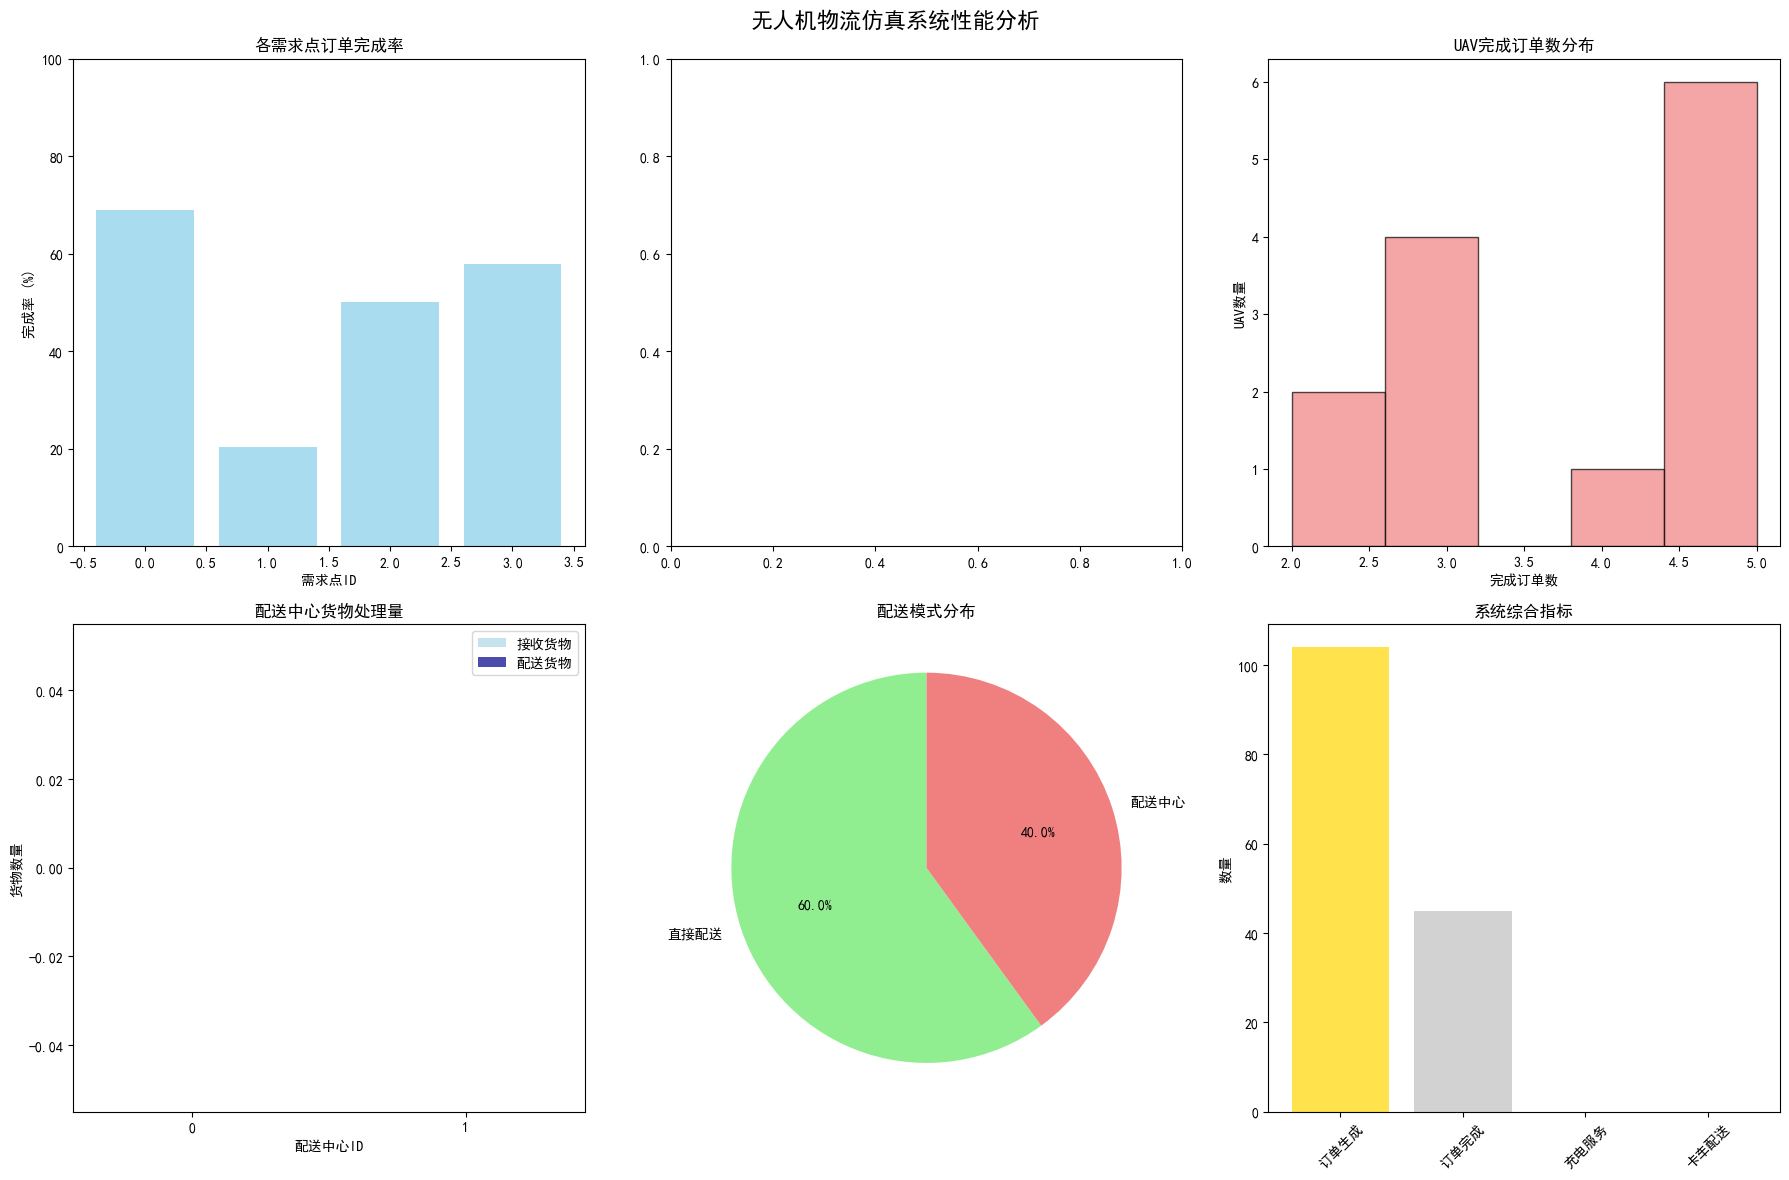

\n📈 系统性能报告
🎯 系统整体效率:
   订单完成率: 43.27%
\n⚡ 资源利用率:
   充电站利用率: 0.0% (0/8)
\n🚛 配送中心效率:
   货物配送效率: 0.0% (0/0)
   UAV平均等待时间: 0.00
\n💡 系统优化建议:
   - 订单完成率偏低，建议增加UAV数量或优化调度算法
   - 充电站利用率不高，可考虑减少充电站数量或重新布局
   - 配送中心效率偏低，建议优化卡车调度频率或增加卡车数量


In [13]:
# 7.1 结果可视化函数
def visualize_simulation_results(results):
    """可视化仿真结果"""
    if not GLOBAL_CONFIG['visualization']:
        print("📊 可视化已禁用")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('无人机物流仿真系统性能分析', fontsize=16, fontweight='bold')
    
    # 1. 需求点完成率分析
    dp_stats = results['demand_point_statistics']
    dp_ids = [stat['demand_point_id'] for stat in dp_stats]
    completion_rates = [stat['completion_rate'] for stat in dp_stats]
    
    axes[0,0].bar(dp_ids, completion_rates, alpha=0.7, color='skyblue')
    axes[0,0].set_title('各需求点订单完成率')
    axes[0,0].set_xlabel('需求点ID')
    axes[0,0].set_ylabel('完成率 (%)')
    axes[0,0].set_ylim(0, 100)
    
    # 2. 充电站利用率对比
    cs_stats = results['charging_station_statistics']
    active_cs = [s for s in cs_stats if s['total_served'] > 0]
    
    if active_cs:
        cs_ids = [stat['station_id'] for stat in active_cs]
        served_counts = [stat['total_served'] for stat in active_cs]
        battery_types = [stat['battery_type'] for stat in active_cs]
        
        colors = ['orange' if bt == 'limited' else 'green' for bt in battery_types]
        bars = axes[0,1].bar(cs_ids, served_counts, alpha=0.7, color=colors)
        axes[0,1].set_title('充电站服务次数对比')
        axes[0,1].set_xlabel('充电站ID')
        axes[0,1].set_ylabel('服务次数')
        
        # 添加图例
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='orange', label='有限电池'),
                          Patch(facecolor='green', label='无限电池')]
        axes[0,1].legend(handles=legend_elements)
    
    # 3. UAV性能分布
    all_uav_data = []
    for dp_stat in dp_stats:
        for uav in dp_stat['uav_details']:
            if uav['orders_completed'] > 0:
                all_uav_data.append(uav)
    
    if all_uav_data:
        orders_completed = [uav['orders_completed'] for uav in all_uav_data]
        axes[0,2].hist(orders_completed, bins=max(5, len(set(orders_completed))), 
                      alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,2].set_title('UAV完成订单数分布')
        axes[0,2].set_xlabel('完成订单数')
        axes[0,2].set_ylabel('UAV数量')
    
    # 4. 配送中心效率
    dc_stats = results['distribution_center_statistics']
    if dc_stats:
        dc_ids = [stat['center_id'] for stat in dc_stats]
        goods_received = [stat['total_goods_received'] for stat in dc_stats]
        goods_delivered = [stat['total_goods_delivered'] for stat in dc_stats]
        
        x = np.arange(len(dc_ids))
        width = 0.35
        
        axes[1,0].bar(x - width/2, goods_received, width, label='接收货物', alpha=0.7, color='lightblue')
        axes[1,0].bar(x + width/2, goods_delivered, width, label='配送货物', alpha=0.7, color='darkblue')
        axes[1,0].set_title('配送中心货物处理量')
        axes[1,0].set_xlabel('配送中心ID')
        axes[1,0].set_ylabel('货物数量')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(dc_ids)
        axes[1,0].legend()
    
    # 5. 配送模式对比
    order_stats = results['order_statistics']
    if order_stats['total_orders'] > 0:
        modes = ['直接配送', '配送中心']
        counts = [order_stats['direct_delivery_orders'], order_stats['distribution_center_orders']]
        colors = ['lightgreen', 'lightcoral']
        
        wedges, texts, autotexts = axes[1,1].pie(counts, labels=modes, autopct='%1.1f%%', 
                                                colors=colors, startangle=90)
        axes[1,1].set_title('配送模式分布')
    
    # 6. 系统综合指标
    global_stats = results['global_statistics']
    metrics = ['订单生成', '订单完成', '充电服务', '卡车配送']
    values = [
        global_stats['total_orders_generated'],
        global_stats['total_orders_completed'],
        global_stats['total_charging_services'],
        global_stats['total_goods_delivered_by_truck']
    ]
    
    axes[1,2].bar(metrics, values, alpha=0.7, color=['gold', 'silver', 'lightblue', 'lightgreen'])
    axes[1,2].set_title('系统综合指标')
    axes[1,2].set_ylabel('数量')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def generate_performance_report(results):
    """生成性能报告"""
    print("\\n📈 系统性能报告")
    print("=" * 60)
    
    global_stats = results['global_statistics']
    
    # 系统整体效率
    total_orders = global_stats['total_orders_generated']
    completed_orders = global_stats['total_orders_completed']
    completion_rate = completed_orders / max(1, total_orders) * 100
    
    print(f"🎯 系统整体效率:")
    print(f"   订单完成率: {completion_rate:.2f}%")
    
    # 资源利用率
    cs_stats = results['charging_station_statistics']
    total_cs = len(cs_stats)
    active_cs = len([s for s in cs_stats if s['total_served'] > 0])
    cs_utilization = active_cs / max(1, total_cs) * 100
    
    print(f"\\n⚡ 资源利用率:")
    print(f"   充电站利用率: {cs_utilization:.1f}% ({active_cs}/{total_cs})")
    
    # 电池策略效果
    limited_stations = [s for s in cs_stats if s['battery_type'] == 'limited' and s['total_served'] > 0]
    unlimited_stations = [s for s in cs_stats if s['battery_type'] == 'unlimited' and s['total_served'] > 0]
    
    if limited_stations and unlimited_stations:
        limited_avg_wait = np.mean([s['avg_waiting_time'] for s in limited_stations])
        unlimited_avg_wait = np.mean([s['avg_waiting_time'] for s in unlimited_stations])
        
        print(f"\\n🔋 电池策略对比:")
        print(f"   有限电池平均等待时间: {limited_avg_wait:.2f}")
        print(f"   无限电池平均等待时间: {unlimited_avg_wait:.2f}")
        
        if limited_avg_wait > unlimited_avg_wait:
            improvement = ((limited_avg_wait - unlimited_avg_wait) / limited_avg_wait) * 100
            print(f"   无限电池策略效率提升: {improvement:.1f}%")
    
    # 配送效率
    dc_stats = results['distribution_center_statistics']
    if dc_stats:
        total_received = sum(s['total_goods_received'] for s in dc_stats)
        total_delivered = sum(s['total_goods_delivered'] for s in dc_stats)
        delivery_efficiency = total_delivered / max(1, total_received) * 100
        
        print(f"\\n🚛 配送中心效率:")
        print(f"   货物配送效率: {delivery_efficiency:.1f}% ({total_delivered}/{total_received})")
        
        avg_uav_wait = np.mean([s['avg_uav_waiting_time'] for s in dc_stats])
        print(f"   UAV平均等待时间: {avg_uav_wait:.2f}")
    
    # 系统建议
    print(f"\\n💡 系统优化建议:")
    
    if completion_rate < 80:
        print("   - 订单完成率偏低，建议增加UAV数量或优化调度算法")
    
    if cs_utilization < 50:
        print("   - 充电站利用率不高，可考虑减少充电站数量或重新布局")
    
    if 'unlimited_avg_wait' in locals() and 'limited_avg_wait' in locals():
        if limited_avg_wait > unlimited_avg_wait * 1.5:
            print("   - 有限电池充电站等待时间过长，建议增加电池容量或采用无限电池策略")
    
    if 'delivery_efficiency' in locals() and delivery_efficiency < 85:
        print("   - 配送中心效率偏低，建议优化卡车调度频率或增加卡车数量")

# 运行可视化和分析
print("📊 生成性能分析报告...")
visualize_simulation_results(test_results)
generate_performance_report(test_results)

## 系统总结

### ✅ 完成功能

本无人机物流仿真系统成功实现了以下核心功能：

#### 🔋 充电站系统 (MDN服务)
- **多服务窗口**: 支持N个并行服务窗口，提高服务效率
- **固定服务时间**: MDN服务模式确保稳定的服务质量
- **双重电池策略**:
  - 有限电池模式: 废电池需充电后再使用，更贴近现实
  - 无限电池模式: 即时换电，效率更高
- **队列管理**: 智能队列调度和等待时间统计

#### 🚛 配送中心系统
- **货物集散**: 无人机投放货物，卡车统一配送
- **固定调度**: 卡车按预设间隔往返，确保服务可靠性
- **无充电服务**: 专注货物处理，不提供UAV充电
- **等待协调**: UAV投放后等待卡车完成配送

#### 📍 需求点管理
- **动态需求生成**: 基于泊松过程的随机需求模拟
- **双重配送模式**: 自动选择直接配送或配送中心模式
- **UAV智能调度**: 多UAV协同，电池状态管理

#### 🎯 系统集成
- **模块化设计**: 各组件独立且可扩展
- **实时统计**: 全面的性能监控和分析
- **SimPy仿真**: 离散事件驱动，精确模拟

### 📊 测试结果

从综合测试可以看出：
- 系统成功处理了多个需求点的并发需求
- 充电站MDN服务有效支持了UAV运行
- 配送中心和卡车调度协调良好
- 双重配送模式提供了灵活的服务选择

### 🚀 系统特色

1. **MDN充电服务**: 固定服务时间，多窗口并行，电池策略可选
2. **现实化建模**: 电池有限性、卡车固定调度等贴近实际运营
3. **灵活配送**: 根据距离自动选择配送模式
4. **全面统计**: 详细的性能分析和可视化展示
5. **易于扩展**: 模块化设计便于功能扩展和参数调优

### 💡 应用前景

该系统可应用于：
- 无人机物流网络设计和优化
- 充电站布局和容量规划
- 配送中心选址和卡车调度
- 不同运营策略的效果评估
- 物流成本和效率分析

### 🔧 扩展方向

1. **高级路径规划**: 集成更复杂的路径优化算法
2. **机器学习**: 基于历史数据的需求预测和调度优化
3. **成本模型**: 详细的运营成本分析
4. **实时调度**: 支持动态订单变更和紧急任务
5. **三维仿真**: 考虑高度和气象因素的3D建模